# Detrending and resampling SIA data, observations and models

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb)

**Input**: <br>
- Models: Arctic SIA from six models of the CLIVAR Large Ensemble archive (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1), as computed in [another notebook](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIC_to_SIA_models.ipynb)
- Observations: Arctic SIA from size observational datasets: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged), as computed in  [another notebook](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb)

**Output**: <br>
- Detrended SIA for models and observations using the individual datasets or member or the average observational dataset or ensemble mean
- Resampled SIA 1000 times wiht a 2 year bootstrap size
- **$\sigma_{LE}$**  : Standard deviations of detrended models without resampling
- **$\sigma_{mem}$** : Standard deviations of detrended resampled models
- **$\sigma_{obs}$** : Standard deivations of detrended resampled observations

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as stats
import datetime

In [6]:
# data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'
data_path = '/glade/campaign/univ/ucub0084/Synthetic_ensemble/'

model_names  = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1' ]
mem_len      = [50,        40,      30,           20,         30,           100        ]
model_starts = [1950,      1920,    1850,         1920,       1950,         1850       ]

In [7]:
#load observational data
CDR  = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIA_SIE_CDR_BT_NT_79-20_filled.nc')
SII      = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_sea_ice_index_v3/NSIDC_sea_ice_index_SIA_SIE_79-20_filled_including_pole_hole.nc')
HadISST1 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_filled.nc')
Merged   = xr.open_dataset(data_path+'Raw_data/observations/merged_Hadley_OI/merged_Hadley_OI_SIA_SIE_79-20.nc')

obs_SIA = xr.Dataset({'CDR':CDR['CDR_SIA'].copy(), 'BT':CDR['BT_SIA'].copy(), 'NT':CDR['NT_SIA'].copy(), 
                     'SII':SII['SIA'].copy(), 'HadISST1':HadISST1['SIA'].copy(), 'Merged':Merged['SIA'].copy()})

obs_SIA_keys = list(obs_SIA.keys())

#load model data
SIA = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')
# SIE = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIE_1850_2100_RCP85.nc')

# Define resampling functions

In [17]:
def resample_boot1(time_period, data):
    '''
    Resample a 1D time series using a 2 year block boostrap size
    
    Parameters
    ----------
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    
    Returns
    ----------
        2D xarray dataarray object of 1000 resamplings of the input data, shape: (time_period, 1000)
    ''' 
    
    resampled = np.random.choice(data, (time_period, 1000), replace=True)
    
    resampled = xr.DataArray(data = np.reshape(resampled, (1000, time_period)),
                             coords = {'resampling':np.arange(1,1001,1), 'year_i':np.arange(1,time_period+1,1)},
                             dims   = ['resampling', 'year_i'])
    
    return(resampled)

In [9]:
def resample_boot2(time_period, data):
    '''
    Resample a 1D time series using a 2 year block boostrap size with replacement
    
    Parameters
    ----------
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    
    Returns
    ----------
        2D xarray dataarray object of 1000 resamplings of the input data, shape: (time_period, 1000)
    '''  
    #create an xarray dataarray of indexes for half the length of the time period, year_i coordinates 1,3,5...
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,time_period-2, (1000,int(time_period/2))), 
                                    coords = {'resampling':np.arange(1,1001,1), 'year_i':np.arange(1,time_period+1,2)},
                                    dims   = ['resampling', 'year_i'])

    #create an identical dataarray but with each element incremented by 1, year_i coordinates 2,4,6....
    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,time_period+2,2)

    #concatenate the two arrays with the coordinates in order, this allows a 2 year block boostrap size
    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    #create an array with the starting element of the flattened array for each resampling 0, 42, 84...
    ind_base = np.repeat(np.arange(0,time_period*1000,time_period),time_period)
    
    #add together the base indexes (0,42,84...) with the randomly chosen indexes within the original data
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base
    
    #copy the original data 1000 times as a 1D array so it will have the same indexes as we just made for ind_1_d
    data_1000 = np.ravel(np.tile(data,(time_period,1000)))
    
    #select the randomly generated indexes from the flattened copied original data, reshape and save to xarray dataarray
    resampled_boot_2 = xr.DataArray(data = np.reshape(data_1000[ind_1_d], (1000, time_period)),
                                    coords = {'resampling':np.arange(1,1001,1), 'year_i':np.arange(1,time_period+1,1)},
                                    dims   = ['resampling', 'year_i'])

    return(resampled_boot_2)

# Observations
## Detrend all observational datasets using average observational trend and individual dataset trends

In [49]:
#compute the average trends
start_yr = 1979
end_yr   = 2020

#calculate the average observations and its trend
obs_mean = (obs_SIA['CDR'] + obs_SIA['BT'] + obs_SIA['NT'] + obs_SIA['SII'] + obs_SIA['HadISST1'] + obs_SIA['Merged']) / 6

mean_trends = []
for month_ in np.arange(1,13,1):
    mean_coefs = np.polyfit(np.arange(start_yr, end_yr+1), obs_mean.sel(time=obs_mean['time.month']==month_).values, 1)
    mean_trend = (mean_coefs[0]*np.arange(start_yr, end_yr+1) + mean_coefs[1])
    mean_trends.append(xr.DataArray(data = mean_trend, coords={'time':obs_mean['time'].sel(time=obs_mean['time.month']==month_)}, dims=['time']))

mean_trends = xr.concat((mean_trends), dim='time')

In [85]:
#detrend observations based on own trend and the mean trend of the 6 datasets
obs_detrend_individual = {}
obs_detrend_average    = {}

for key in obs_SIA_keys:   
    detrend_individual_list = []
    
    for month_ in np.arange(1,13):
        coefs = np.polyfit(np.arange(start_yr, end_yr+1), obs_SIA[key].sel(time=obs_SIA['time.month']==month_), 1)
        detrend_individual_list.append(-1*(coefs[0]*np.arange(start_yr, end_yr+1) + coefs[1]) + obs_SIA[key].sel(time=obs_SIA['time.month']==month_))
        
    obs_detrend_individual[key] = xr.concat((detrend_individual_list), dim='time')
    obs_detrend_average[key]    = obs_SIA[key] - mean_trends[key]

In [30]:
#detrend based on deleting a number of values from the time series at random
len_rand = 32 #number of randomly chosen elements to be deleted - see figures at end of notebook
n_jackknife = 50

detrended_jackknife = {}

for dataset in obs_SIA_keys:
    detrended_jackknife_months = []
    
    for month_ in np.arange(1,13):
        np_data = np.array(obs_SIA[dataset].sel(time=obs_SIA['time.month']==month_).sel(time=slice('1979','2020')).copy())
        np_dates = np.arange(1979,2021)

        obs_coefs = np.empty((50,2))
        for i in range(n_jackknife):
            rand_ints = np.random.default_rng().choice(len(np_data), size=len_rand, replace=False)
            temp_SIA = np.delete(np_data.copy(), rand_ints)
            temp_dates = np.delete(np_dates.copy(), rand_ints)
            obs_coefs[i] = np.polyfit(temp_dates, temp_SIA, 1)

        obs_data = xr.DataArray(data=np.tile(np_data,(50,1)), coords={'jackknife':np.arange(0,50), 'time':np.arange(1979,2021)}, dims=['jackknife', 'time'])

        obs_coefs = xr.DataArray(data=obs_coefs, coords={'jackknife':np.arange(0,50), 'coef':['gradient','intercept']}, dims=['jackknife', 'coef'])

        obs_jackknife_trends = obs_coefs.sel(coef='gradient') * obs_data['time'] + obs_coefs.sel(coef='intercept')

        detrended_jackknife_months.append(obs_data - obs_jackknife_trends)

    detrended_jackknife_dataset = xr.concat((detrended_jackknife_months), dim='month')
    detrended_jackknife_dataset['month'] = np.arange(1,13)
    detrended_jackknife[dataset] = detrended_jackknife_dataset

In [34]:
#save detrended observations to NetCDF
dict_attrs = {'Description': 'Detrended Arctic sea ice area (SIA) for six observational datasets 1979-2020: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). The trend for each month of each dataset is used for detrending.', 
              'Units'      : 'million square km',
              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
              'Data source': 'DOIs - CRD, BT, NT:10.7265/efmz-2t65, SII:10.7265/N5K072F8, HadISST1:10.1029/2002JD002670, Merged:10.5065/r33v-sv91',
              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

#save detrended observations by individual trends
obs_detrend_individual = xr.Dataset(obs_detrend_individual)
obs_detrend_individual.attrs = dict_attrs
obs_detrend_individual.to_netcdf(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_individual_79-20.nc')

#save detrended observations by average trends of the 6 models
ave_attrs = dict_attrs.copy()
ave_attrs['Description'] = 'Detrended Arctic sea ice area (SIA) for six observational datasets 1979-2020: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). The trend calculated from the average of the six datasets is used to detrend the datasets for each month.'

obs_detrend_average = xr.Dataset(obs_detrend_average)
obs_detrend_average.attrs = ave_attrs
obs_detrend_average.to_netcdf(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_average_79-20.nc')

#save detrended observations by 50 jacknife simulated members
jackknife_attrs = dict_attrs.copy()
jackknife_attrs['Description'] = 'Detrended Arctic sea ice area (SIA) for six observational datasets 1979-2020: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). The trend calculated from 50 jackknifed subsets of the data containing 30 of the 42 time steps.'

detrended_jackknife = xr.Dataset(detrended_jackknife)
detrended_jackknife.attrs = jackknife_attrs
detrended_jackknife.to_netcdf(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_jackknife_79-20.nc')

## Resample all detrended observational data sets

In [10]:
#import detrended data
# obs_detrend_average     = xr.open_dataset(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_average_79-20.nc')
obs_detrend_individual  = xr.open_dataset(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_individual_79-20.nc')
# obs_detrended_jackknife = xr.open_dataset(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_jackknife_79-20.nc')

In [20]:
#calculate the resamplings of all observational datasets and months
#to change the bootstrap size, change the function names: [resample_boot2, resample_boot1]

for run in np.arange(1,11): #make repeated runs to add to randomness
    print(datetime.datetime.now(), run)

    obs_resample_individual = {}
    # obs_resample_average    = {}
    # obs_resample_jackknife  = {}

    for key in obs_SIA_keys:           
        resampled_individual_month = []
    #     resampled_average_month    = []
    #     resampled_jackknifes_month = []

        for month_ in np.arange(1,13): #N.B. remember to change boot1 or boot2
            resampled_individual_month.append(resample_boot1(42, obs_detrend_individual[key].sel(time=obs_detrend_individual['time.month']==month_)))
    #         resampled_average_month.append(resample_boot2(42, obs_detrend_average[key].sel(time=obs_detrend_average['time.month']==month_)))

    #         jackknifes = []
    #         for jack_n in obs_detrended_jackknife['jackknife']:
    #             jackknifes.append(resample_boot2(42, obs_detrended_jackknife[key].sel(jackknife=jack_n).sel(month=month_)))

    #         resampled_jackknifes_month.append(xr.concat((jackknifes), dim='jackknife')) 


        obs_resample_individual[key] = xr.concat((resampled_individual_month), dim='month')
    #     obs_resample_average[key]    = xr.concat((resampled_average_month), dim='month')
    #     obs_resample_jackknife[key]  = xr.concat((resampled_jackknifes_month), dim='month')

    obs_resample_individual = xr.Dataset(obs_resample_individual)
    obs_resample_individual['month'] = np.arange(1,13)

    # obs_resample_average = xr.Dataset(obs_resample_average)
    # obs_resample_average['month'] = np.arange(1,13)

    # obs_resample_jackknife = xr.Dataset(obs_resample_jackknife)
    # obs_resample_jackknife['month'] = np.arange(1,13)


    #save the resampled data to NetCDF
    dict_attrs = {'Description': 'Resampled Arctic sea ice area 1979-2020 for six datasets: Climate Data Record (CDR), NASA Bootstrap (BT), '\
                  +'NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). '\
                  +'The trend for each month for each dataset is used for detrending, resampling is done 1000 times with a 1 year bootstrap size.', 
                  'Units'      : 'million square km',
                  'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                  'Data source': 'DOIs - CRD, BT, NT:10.7265/efmz-2t65, SII:10.7265/N5K072F8, HadISST1:10.1029/2002JD002670, Merged:10.5065/r33v-sv91',
                  'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

    #save resampled SIA using individual trends
    obs_resample_individual = xr.Dataset(obs_resample_individual)
    obs_resample_individual.attrs = dict_attrs
    # obs_resample_individual.to_netcdf(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_individual_79-20_run{}.nc'.format(run))
    obs_resample_individual.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Obs_SIA_resampled_individual_79-20_boot1_run{}.nc'.format(run))

    # #save resampled SIA using dataset average trends
    # ave_attrs = dict_attrs.copy()
    # ave_attrs['Description'] = 'Resampled Arctic sea ice area (SIA) for six observational datasets 1979-2020: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). The trend calculated from the average of the six datasets is used to detrend the datasets for each month, resampling is done 1000 times with a 2 year bootstrap size.'

    # obs_resample_average = xr.Dataset(obs_resample_average)
    # obs_resample_average.attrs = ave_attrs
    # obs_resample_average.to_netcdf(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_average_79-20.nc')

    # #save resampled SIA using dataset jackknife trends
    # jackknife_attrs = dict_attrs.copy()
    # jackknife_attrs['Description'] = 'Resampled Arctic sea ice area (SIA) for six observational datasets 1979-2020: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). The trend calculated from 50 jackknifed subsets (30 of the 42 time steps) of the six datasets is used to detrend the datasets for each month, resampling is done 1000 times with a 2 year bootstrap size.'

    # obs_resample_jackknife = xr.Dataset(obs_resample_jackknife)
    # obs_resample_jackknife.attrs = jackknife_attrs
    # obs_resample_jackknife.to_netcdf(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_jackknife_79-20.nc')

# Models

## Detrend model data using ensemble mean trends and individual member trends

In [29]:
start_yr = 1979
end_yr   = 2020

all_model_detrend_ensemble   = {}
all_model_detrend_individual = {}

for model_i, model_name in enumerate(model_names):
    
    detrend_ensemble_list  = []
    detrend_individual_list = []
    
    for month_ in np.arange(1,13):
        
        if model_name == 'MPI_ESM1': #100 elements in member dimension so can't select all of those for MPI ESM1
            model_month = SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice(str(start_yr),str(end_yr)))
        else:
            model_month = SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice(str(start_yr),str(end_yr))).sel(member=slice('1',str(mem_len[model_i])))

        #detrend all members by the ensemble mean trend
        ensemble_coefs = np.polyfit(np.arange(start_yr, end_yr+1), model_month.mean('member').values, 1)
        detrend_ensemble_list.append(model_month - (ensemble_coefs[0]*np.arange(start_yr, end_yr+1) + ensemble_coefs[1]))

        #detrend the individual members with their own trend
        yr_list = xr.DataArray(data = np.arange(1979,2021,1), coords={'time':model_month['time']}, dims=['time'])
        
        mem_coefs  = np.polyfit(np.arange(start_yr, end_yr+1), model_month.transpose().values, 1)
        mem_coefs  = xr.DataArray(data = mem_coefs, coords={'coef':['grad', 'intercept'], 'member':np.arange(1,mem_len[model_i]+1)}, dims=['coef', 'member'])

        detrend_individual_list.append(model_month - (mem_coefs.sel(coef='grad')*yr_list + mem_coefs.sel(coef='intercept')))
        
    all_model_detrend_ensemble[model_name]   = xr.concat((detrend_ensemble_list), dim='time')
    all_model_detrend_individual[model_name] = xr.concat((detrend_individual_list), dim='time')

In [30]:
#save detrended SIA using ensemble trends
all_model_detrend_ensemble   = xr.Dataset(all_model_detrend_ensemble)

dict_attrs = {'Description': 'Detrended Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Ensemble mean trend is used to detrend each member.', 
              'Units'      : 'million square km',
              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
              'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

all_model_detrend_ensemble.attrs = dict_attrs
all_model_detrend_ensemble.to_netcdf(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_ensemble_79-20.nc')

#save detrended SIA using individual trends
all_model_detrend_individual = xr.Dataset(all_model_detrend_individual)
individual_attrs = dict_attrs.copy()
individual_attrs['Description'] = 'Detrended Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Each individual member trend is used to detrend.'
all_model_detrend_individual.attrs = individual_attrs
all_model_detrend_individual.to_netcdf(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_individual_79-20.nc')

## Resample models, 2 year bootstrap size, 1000 times

In [21]:
#import detrended data
# detrend_ensemble   = xr.open_dataset(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_ensemble_79-20.nc')
detrend_individual = xr.open_dataset(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_individual_79-20.nc')

In [48]:
#calculate the resamplings of all models and months
#to change the bootstrap size, change the function names: [resample_boot2, resample_boot1]
# resampled_ensemble_model   = {}
resampled_individual_model = {} 

for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
#     resampled_ensemble_month   = []
    resampled_individual_month = [] 
    
    for month_ in np.arange(1,13):
        
#         resampled_ensemble_member   = []
        resampled_individual_member = [] 
        
        for mem_ in np.arange(1,mem_len[model_i]+1):
            #select a 1D array of detrended anomalies, resample these 1000 times for each member
#             resampled_ensemble_member.append(resample_boot2(42, detrend_ensemble[model_name].sel(time=detrend_ensemble['time.month']==month_).sel(member=mem_)))
            resampled_individual_member.append(resample_boot1(42, detrend_individual[model_name].sel(time=detrend_individual['time.month']==month_).sel(member=mem_)))
        
        #concatenate all the member output data and append it to the list containing data for all months
#         resampled_ensemble_month.append(xr.concat((resampled_ensemble_member), dim='member'))
        resampled_individual_month.append(xr.concat((resampled_individual_member), dim='member'))
            
#     resampled_ensemble_model[model_name] = xr.concat((resampled_ensemble_month), dim='month')
#     resampled_ensemble_model[model_name]['member'] = np.arange(1,mem_len[model_i]+1)
    resampled_individual_model[model_name] = xr.concat((resampled_individual_month), dim='month')
    resampled_individual_model[model_name]['member'] = np.arange(1,mem_len[model_i]+1)

2022-04-18 15:00:59.040626 CanESM2
2022-04-18 15:01:01.373574 CESM1
2022-04-18 15:01:03.185813 CSIRO_MK36
2022-04-18 15:01:04.629062 GFDL_CM3
2022-04-18 15:01:05.556271 GFDL_ESM2M
2022-04-18 15:01:06.888336 MPI_ESM1


In [49]:
#save the resampled data to NetCDF
# resampled_ensemble_model   = xr.Dataset(resampled_ensemble_model)
# resampled_ensemble_model['month'] = np.arange(1,13)

dict_attrs = {'Description': 'Resampled Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, '\
              +'GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Ensemble mean trend is used to detrend each member. '\
              +'Resampling is done 1000 times with a 1 year bootstrap size.', 
              'Units'      : 'million square km',
              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
              'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

# resampled_ensemble_model.attrs = dict_attrs
# resampled_ensemble_model.to_netcdf(data_path+'SIA/SIA_resampled/CLIVAR_SIA_resampled_ensemble_79-20_run2.nc')

#save detrended SIA using individual trends
resampled_individual_model = xr.Dataset(resampled_individual_model)
resampled_individual_model['month'] = np.arange(1,13)
individual_attrs = dict_attrs.copy()
# individual_attrs['Description'] = 'Resampled Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Each individual member trend is used to detrend. Resampling is done 1000 times with a 2 year bootstrap size.'
resampled_individual_model.attrs = individual_attrs
# resampled_individual_model.to_netcdf(data_path+'SIA/SIA_resampled/CLIVAR_SIA_resampled_individual_79-20_run1.nc')
resampled_individual_model.std('year_i').to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_individual_79-20_boot1_run10.nc')
resampled_individual_model.mean('year_i').to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Mu_mem_individual_79-20_boot1_run10.nc')

## Compute SD time with 10 runs for 10,000 resamplings in total

In [11]:
all_runs_models = []
all_runs_obs = []

for run in np.arange(1,11): #loop through the 10 files of 1000 random resamplings each
    if run == 1:
        resampled_models = xr.open_dataset(data_path+'SIA/SIA_resampled/CLIVAR_SIA_resampled_individual_79-20.nc')
        resampled_obs = xr.open_dataset(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_individual_79-20.nc')
    else:
        resampled_models = xr.open_dataset(data_path+'SIA/SIA_resampled/CLIVAR_SIA_resampled_individual_79-20_run{}.nc'.format(run))
        resampled_obs = xr.open_dataset(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_individual_79-20_run{}.nc'.format(run))
    
    SD_time_models = resampled_models.std('year_i')
    SD_time_models['resampling'] = np.arange((run-1)*1000 +1, run*1000 +1) #uniquely index the resamplings
    all_runs_models.append(SD_time_models)
    
    SD_time_obs = resampled_obs.std('year_i')
    SD_time_obs['resampling'] = np.arange((run-1)*1000 +1, run*1000 +1) #uniquely index the resamplings
    all_runs_obs.append(SD_time_obs)

# all_runs_models = xr.concat((all_runs_models), dim='resampling')
all_runs_obs    = xr.concat((all_runs_obs), dim='resampling')

#compute the standard deviation and mean across resamplings
sigma_mem_10000 = all_runs_models.std('resampling')
mu_mem_10000    = all_runs_models.mean('resampling')

sigma_obs_10000 = all_runs_obs.std('resampling')
mu_obs_10000    = all_runs_obs.mean('resampling')

In [12]:
#save to netcdf with attributes
sigma_attrs_dict = {'Description': 'Variability of Arctic sea ice area (SIA) of six large ensembles 1979-2020 (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Standard deviation with respect to 10000 resamplings with a 2 year bootstrap size. Detrending was based on the single model ensemble mean trend.', 
                    'Units'      : 'million square km',
                    'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                    'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
                    'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

mu_attrs_dict = sigma_attrs_dict.copy()
mu_attrs_dict['Description'] = 'Variability of Arctic sea ice area (SIA) of six large ensembles 1979-2020 (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Mean of 10000 resamplings with a 2 year bootstrap size. Detrending was based on the single model ensemble mean trend.', 

sigma_mem_10000.attrs = sigma_attrs_dict
sigma_mem_10000.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_mem_individual_10000.nc')

mu_mem_10000.attrs = mu_attrs_dict
mu_mem_10000.to_netcdf(data_path+'SIA/SIA_resampled/Mu_mem_individual_10000.nc')

#save sigma and mu obs
sigma_obs_attrs = sigma_attrs_dict.copy()
sigma_obs_attrs['Description'] = 'Variability of Arctic sea ice area (SIA) of six observational datasets 1979-2020 (six datasets: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). Standard deviation with respect to the standard deviation with respect to time for each 10000 resamplings with a 2 year bootstrap size. Detrending was based on the trend of the individual dataset.' 
sigma_obs_attrs['Data source'] = 'DOIs - CRD, BT, NT:10.7265/efmz-2t65, SII:10.7265/N5K072F8, HadISST1:10.1029/2002JD002670, Merged:10.5065/r33v-sv91'
sigma_obs_10000.attrs = sigma_obs_attrs
sigma_obs_10000.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_obs_individual_10000.nc')

mu_obs_attrs = sigma_obs_attrs.copy()
mu_obs_attrs['Description'] = 'Variability of Arctic sea ice area (SIA) of six observational datasets 1979-2020 (six datasets: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), NSIDC Sea Ice Index (SII), Hadley Centre Sea Ice (HadISST1), Merged Hadley NOAA Optimal Interpolation (Merged). Mean of the standard deviation with respect to time for each 10000 resamplings with a 2 year bootstrap size. Detrending was based on the trend of the individual dataset.'
mu_obs_10000.attrs = mu_obs_attrs
mu_obs_10000.to_netcdf(data_path+'SIA/SIA_resampled/Mu_obs_individual_10000.nc')


# $\sigma_{LE}$ , $\sigma_{mem}$ , $\sigma_{obs}$ calculations
## $\sigma_{LE}$

In [4]:
#load detrended model data
detrend_ensemble   = xr.open_dataset(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_ensemble_79-20.nc')
detrend_individual = xr.open_dataset(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_individual_79-20.nc')

#compute standard deviation along the member dimension
sigma_LE_ensemble   = detrend_ensemble.groupby('time.month').std('time').std('member')
sigma_LE_individual = detrend_individual.groupby('time.month').std('time').std('member')

#save to NetCDF
attrs_dict = {'Description': 'Variability of Arctic sea ice area (SIA) of six large ensembles 1979-2020 (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Standard deviation with respect to members. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on the single model ensemble mean trend.', 
              'Units'      : 'million square km',
              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
              'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

sigma_LE_ensemble.attrs = attrs_dict
sigma_LE_ensemble.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_LE_ensemble_79-20.nc')

ind_attrs_dict = attrs_dict.copy()
ind_attrs_dict['Description'] = 'Variability of Arctic sea ice area (SIA) of six large ensembles 1979-2020 (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Standard deviation with respect members. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on the individual member trend.' 
sigma_LE_individual.attrs = ind_attrs_dict
sigma_LE_individual.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_LE_individual_79-20.nc')

## $\sigma_{mem}$

In [5]:
#load resampled model data
resampled_ensemble   = xr.open_dataset(data_path+'SIA/SIA_resampled/CLIVAR_SIA_resampled_ensemble_79-20.nc')
resampled_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/CLIVAR_SIA_resampled_individual_79-20.nc')

#compute standard deviation along the resampling dimension
sigma_mem_ensemble   = resampled_ensemble.std('year_i').std('resampling')
sigma_mem_individual = resampled_individual.std('year_i').std('resampling')

#save to NetCDF
attrs_dict = {'Description': 'Variability of Arctic sea ice area (SIA) of six large ensembles 1979-2020 (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Standard deviation with respect to 1000 resamplings. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on the single model ensemble mean trend.', 
              'Units'      : 'million square km',
              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
              'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

sigma_mem_ensemble.attrs = attrs_dict
sigma_mem_ensemble.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_79-20.nc')

ind_attrs_dict = attrs_dict.copy()
ind_attrs_dict['Description'] = 'Variability of Arctic sea ice area (SIA) of six large ensembles 1979-2020 (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Standard deviation with respect to 1000 resamplings. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on the individual member trend.' 
sigma_mem_individual.attrs = ind_attrs_dict
sigma_mem_individual.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_mem_individual_79-20.nc')

## $\sigma_{obs}$

In [6]:
#load resampled observational data
obs_resample_average    = xr.open_dataset(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_average_79-20.nc')
obs_resample_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_individual_79-20.nc')
obs_resample_jackknife  = xr.open_dataset(data_path+'SIA/SIA_resampled/Obs_SIA_resampled_jackknife_79-20.nc')

#compute standard deviation along the resampling dimension
sigma_obs_average    = obs_resample_average.std('year_i').std('resampling')
sigma_obs_individual = obs_resample_individual.std('year_i').std('resampling')
sigma_obs_jackknife  = obs_resample_jackknife.std('year_i').std('resampling')

#save to NetCDF
attrs_dict = {'Description': 'Variability of Arctic sea ice area (SIA) observations 1979-2020. Standard deviation with respect to 1000 resamplings. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on the mean dataset trend.', 
              'Units'      : 'million square km',
              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
              'Data source': 'DOIs - CRD, BT, NT:10.7265/efmz-2t65, SII:10.7265/N5K072F8, HadISST1:10.1029/2002JD002670, Merged:10.5065/r33v-sv91',
              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_detrending_resampling.ipynb'}

#save sigma_obs average
sigma_obs_average.attrs = attrs_dict
sigma_obs_average.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_obs_average_79-20.nc')

#save sigma_obs individual
ind_attrs_dict = attrs_dict.copy()
ind_attrs_dict['Description'] = 'Variability of Arctic sea ice area (SIA) observations 1979-2020. Standard deviation with respect to 1000 resamplings. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on the individual dataset trend.' 
sigma_obs_individual.attrs = ind_attrs_dict
sigma_obs_individual.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_obs_individual_79-20.nc')

#save sigma_obs jackknife
jackknife_attrs_dict = attrs_dict.copy()
jackknife_attrs_dict['Description'] = 'Variability of Arctic sea ice area (SIA) observations 1979-2020. Standard deviation with respect to 1000 resamplings. Computed on the detrended standard deviations with respect to time for each month. Detrending was based on 50 jackknifed subsets (30 of the 42 time steps) of the six datasets.' 
sigma_obs_jackknife.attrs = jackknife_attrs_dict
sigma_obs_jackknife.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_obs_jackknife_79-20.nc')

# Investigate detrending observations with member mean from models - didn't work very well

In [6]:
import matplotlib.pyplot as plt

model_print_names = ['CanESM2', 'CESM1', 'CSIRO MK36', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1'] #for printing on graphs
colors = ['m',     'b',   'g',        'orange',  'k',        'tab:olive' ]
obs_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [7]:
all_model_detrend_ensemble = xr.open_dataset(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_ensemble_79-20.nc')
all_model_detrend_individual = xr.open_dataset(data_path+'SIA/SIA_detrended/CLIVAR_SIA_detrended_individual_79-20.nc')
obs_detrend_individual = xr.open_dataset(data_path+'SIA/SIA_detrended/Obs_SIA_detrended_individual_79-20.nc')

start_yr = 1979
end_yr = 2020
trend_ens = {}

yr_xr = xr.DataArray(data = np.arange(start_yr, end_yr+1), coords={'time':np.arange(start_yr, end_yr+1)}, dims=['time'])

for model_i, model_name in enumerate(model_names):
    detrend_ensemble_list  = []
    
    for month_ in np.arange(1,13):
        
        if model_name == 'MPI_ESM1': #100 elements in member dimension so can't select all of those for MPI ESM1
            model_month_ = SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice(str(start_yr),str(end_yr)))
        else:
            model_month_ = SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice(str(start_yr),str(end_yr))).sel(member=slice('1',str(mem_len[model_i])))

        #detrend all members by the ensemble mean trend
        model_month = model_month_.copy()
        model_month['time'] = np.arange(start_yr, end_yr+1)
        
        ensemble_coefs = model_month.mean('member').polyfit(dim='time', deg=1)
        ens_trend = (ensemble_coefs['polyfit_coefficients'].sel(degree=1) * yr_xr + ensemble_coefs['polyfit_coefficients'].sel(degree=0))
        ens_trend['time'] = model_month_['time']
        detrend_ensemble_list.append(ens_trend)

    trend_ens[model_name] = xr.concat((detrend_ensemble_list), dim='time')
    trend_ens[model_name] = trend_ens[model_name].sortby('time')
    
trend_ens = xr.Dataset(trend_ens)

#detrend obs

detrended_obs = {}
for dataset in list(obs_SIA.keys()):
    for model_name in model_names:
        month_data = []
        for month_ in np.arange(1,13):
            month_data.append(obs_SIA[dataset].sel(time=obs_SIA['time.month']==month_) - trend_ens[model_name].sel(time=trend_ens['time.month']==month_))

        detrended_obs[str(model_name)+'_'+str(dataset)] = xr.concat((month_data), dim='time')

    detrended_obs = xr.Dataset(detrended_obs)

detrend_obs_SD_time = detrended_obs.groupby('time.month').std('time')

In [11]:
#plot the standard deviaton of anomalies when obs datasets are detrended by 
#the ensemble mean, and the members detrended by ensemble mean

x_ = [0,0,0,1,1,1]
y_ = [0,1,2,0,1,2]

month_ = 3

fig, axes = plt.subplots(2,3,figsize=[14,7])

for model_i, model_name in enumerate(model_names):
    for data_i, dataset in enumerate(list(obs_SIA.keys())):
        axes[x_[model_i]][y_[model_i]].axvline(detrend_obs_SD_time[str(model_name)+'_'+str(dataset)].sel(month=month_), c=obs_colors[data_i], linestyle='--', linewidth=2, label=dataset)

    axes[x_[model_i]][y_[model_i]].hist(all_model_detrend_ensemble[model_name].sel(time=all_model_detrend_ensemble['time.month']==month_).std('time'), 
                                        bins=np.arange(0.15,0.8,0.01), density=True, color='0.5', label=model_print_names[model_i]);

    mean_mem = all_model_detrend_ensemble[model_name].sel(time=all_model_detrend_ensemble['time.month']==month_).std('time').mean()
    SD_mem   = all_model_detrend_ensemble[model_name].sel(time=all_model_detrend_ensemble['time.month']==month_).std('time').std()

    if x_[model_i] == 1:
        axes[x_[model_i]][y_[model_i]].set_xlabel('Standard deviation of anomalies')
    axes[x_[model_i]][y_[model_i]].set_ylabel('Normalized frequency')
    axes[x_[model_i]][y_[model_i]].set_title(model_print_names[model_i])

In [12]:
# % difference plot of ens vers ind for observational datasets and models
month_ = 9

model_diffs = np.empty((6))
for model_i, model_name in enumerate(model_names):
    ind_SD = all_model_detrend_individual[model_name].sel(time=all_model_detrend_individual['time.month']==month_).std('time').mean('member')
    ens_SD = all_model_detrend_ensemble[model_name].sel(time=all_model_detrend_ensemble['time.month']==month_).std('time').mean('member')
    model_diffs[model_i] = ((ens_SD-ind_SD)/ind_SD)

obs_diffs = np.empty((6,6))
for data_i, dataset in enumerate(list(obs_SIA.keys())):
    for model_i, model_name in enumerate(model_names):
        ind_SD = obs_detrend_individual[dataset].sel(time=obs_detrend_individual['time.month']==month_).std('time')
        ens_SD = detrend_obs_SD_time['{}_{}'.format(model_name, dataset)].sel(month=month_)
        obs_diffs[data_i][model_i] = ((ens_SD-ind_SD)/ind_SD)


for data_i, dataset in enumerate(list(obs_SIA.keys())):
    plt.bar(np.arange(0,6)+(0.1*data_i), obs_diffs[data_i]*100, width=0.1, label=dataset)

plt.bar(np.arange(0.6,6.6), model_diffs*100, width=0.1, label='CLIVAR', color='k')

plt.bar(np.arange(6,6.61,0.1), np.append(np.mean(obs_diffs, axis=1), np.mean(model_diffs))*100, width=0.1, color=obs_colors)

# plt.legend()
plt.xticks(np.arange(0,7), np.append(model_print_names, 'Average'), rotation = 45)
plt.ylabel('% Difference Ens - Ind')
plt.xlabel('Model');
plt.title(month_names[month_-1]);

# Make plot of Jackknife anomalies for obs and ensemble anomalies for models

In [13]:
#determine the number of elements to be deleted - 32 seems to fit best
x_ = [0,0,0,1,1,1,2,2,2,3,3,3]
y_ = [0,1,2,0,1,2,0,1,2,0,1,2]

fig, axes = plt.subplots(4,3,figsize=[14,10])

for i, month_ in enumerate(np.arange(1,13)):
    for model_i, model_name in enumerate(model_names):
        pdf_vals = PDF(all_coefs.sel(coef='gradient').sel(model=model_name))
        axes[x_[i]][y_[i]].plot(pdf_vals[0], pdf_vals[1], color=colors[model_i])
    
    for data_ in ave_grad['dataset']:
        pdf_vals = PDF(all_runs_grad.sel(dataset=data_).sel(month=month_))
        axes[x_[i]][y_[i]].plot(pdf_vals[0], pdf_vals[1], color='r', alpha=0.5, linestyle='--')
        
    axes[x_[i]][y_[i]].set_ylim(bottom=0)
    axes[x_[i]][y_[i]].set_xlim(-0.1, 0.01)    
    axes[x_[i]][y_[i]].set_title(month_names[i])
    
    if x_[i] == 3:
        axes[x_[i]][y_[i]].set_xlabel('Gradient')
    if y_[i] == 0:
        axes[x_[i]][y_[i]].set_ylabel('Normalized Frequency')
    
plt.tight_layout()

## Compare 1 and 2 year bootstrap sizes

In [72]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

member_numbers = [50, 40, 30, 20, 30, 100]
month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['m',     'b',   'g',        'orange',  'k',        'tab:olive' ]


In [ ]:
#load 2 year block size
sigma_mem_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_79-20.nc')
sigma_obs_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_obs_individual_79-20.nc')

In [52]:
all_run = []
for run_ in np.arange(1,11):
    run_boot = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_individual_79-20_boot1_run{}.nc'.format(run_))
    run_boot['resampling'] = np.arange((1000*run_)-999, (1000*run_)+1)
    all_run.append(run_boot)
    
sigma_mem_boot1 = xr.concat((all_run),dim='resampling').std('resampling')

In [61]:
all_run = []
for run_ in np.arange(1,11):
    run_boot = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Obs_SIA_resampled_individual_79-20_boot1_run{}.nc'.format(run))
    run_boot['resampling'] = np.arange((1000*run_)-999, (1000*run_)+1)
    all_run.append(run_boot)
    
sigma_obs_boot1 = xr.concat((all_run),dim='resampling').std('year_i').std('resampling')

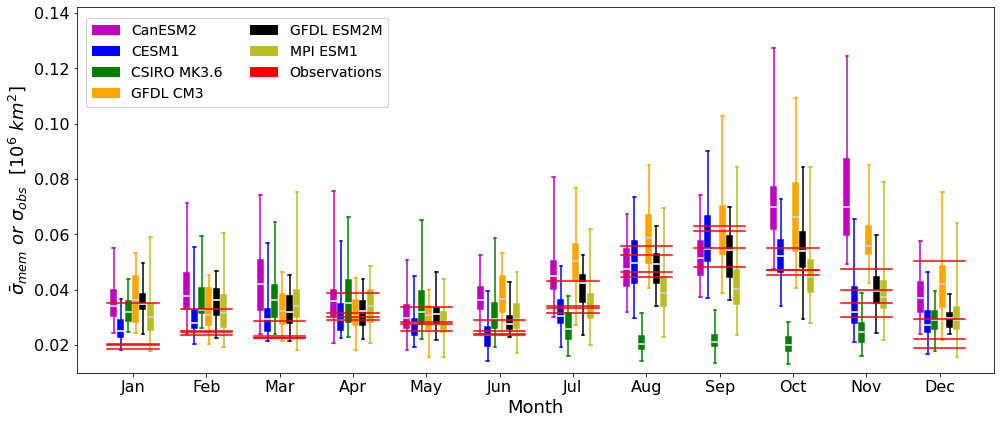

In [73]:
sigma_mu = 'sigma'

if sigma_mu == 'sigma':
    mem = sigma_mem_boot1.copy()
    obs = sigma_obs_boot1.to_array().sel(variable=['CDR','BT','NT','HadISST1'])
else:
    mem = mu_mem.copy()
    obs = mu_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1'])
    
fig = plt.figure(figsize=[14,6])

for model_i, model_name in enumerate(model_names):
    boxplot_model = np.empty((member_numbers[model_i],12))
    
    for memb_i, memb in enumerate(np.arange(1,member_numbers[model_i]+1)):    
        boxplot_model[memb_i] = mem[model_name].sel(member=memb).values
    
    b_plot = plt.boxplot(boxplot_model, widths=0.07, positions=np.arange(0.735+model_i*0.1,12.735+model_i*0.1,1), 
                         whis=(0,100), labels=month_names_short, patch_artist=True);
    
    #set the colors
    for patch in b_plot['boxes']: 
        patch.set_facecolor(colors[model_i]) 
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(b_plot[element], color=colors[model_i], linewidth=1.5)
        
    plt.setp(b_plot['medians'], color='0.8', linewidth=2)
    
marker_list = ['o',8,9,'d','s']
for var_i in range(4):
    for month_ in np.arange(1,13):
        plt.plot([-0.35+month_, 0.35+month_], [obs.isel(variable=var_i).sel(month=month_), obs.isel(variable=var_i).sel(month=month_)], c='r', alpha=1, zorder=9)
#     plt.scatter(np.arange(0.6,12.6), obs.isel(variable=var_i), c='r', marker=marker_list[var_i])

legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK3.6'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),
                   Patch(facecolor='r', label='Observations')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(0.01, 0.97), loc='upper left', borderaxespad=0, ncol=2, fontsize=14)
plt.gca().add_artist(extra_legend);
    
plt.xticks(np.arange(1,13), fontsize=16)
plt.xlabel('Month', fontsize=18)
plt.yticks(fontsize=16)

if sigma_mu == 'sigma':
    plt.ylim(0.01,0.142) #for sigma
    plt.ylabel(r'$\bar{\sigma}_{mem} \ or \ \sigma_{obs} \ \ [10^6 \ km^2]$', fontsize=18);
else:
    plt.ylim(0.1,0.85) #for mu
    plt.ylabel(r'$\bar{\mu}_{mem} \ or \ \mu_{obs} \ \ [10^6 \ km^2]$', fontsize=18);

plt.tight_layout()

# fig.savefig(data_path+'SIA/figures/Resampled_figures/Mem_obs_bar_chart_{}.png'.format(sigma_mu), dpi=400)
# fig.savefig(data_path+'SIA/figures/Resampled_figures/Mem_obs_bar_chart_{}.pdf'.format(sigma_mu))